# NFA prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

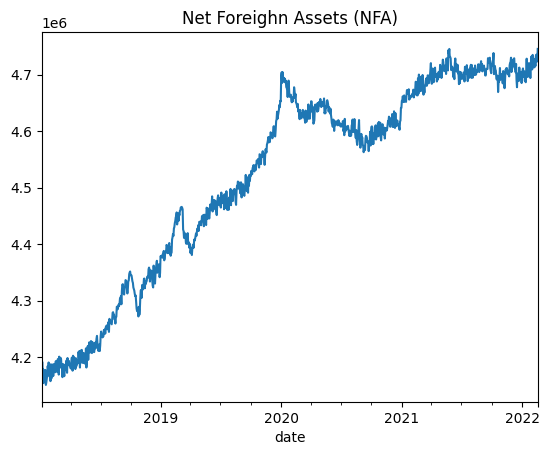

In [2]:
data = pd.read_excel('../data/NFA.xlsx', parse_dates=['date'], index_col='date')
data['NFA'].plot(title = 'Net Foreighn Assets (NFA)'); plt.show()

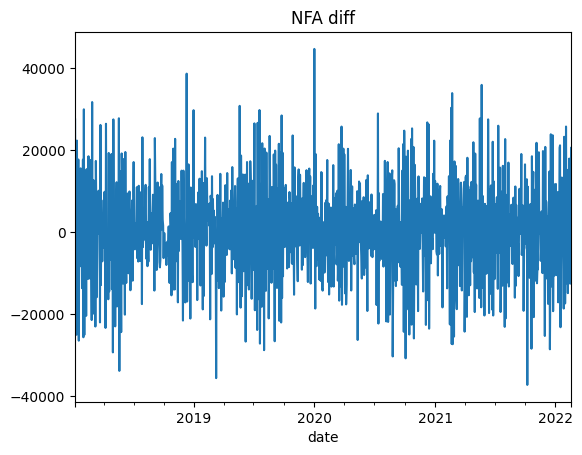

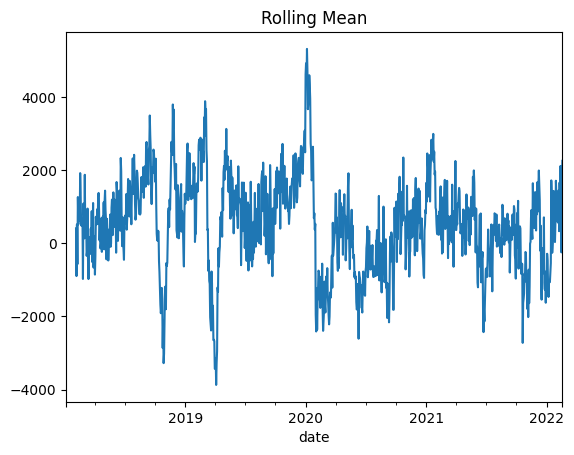

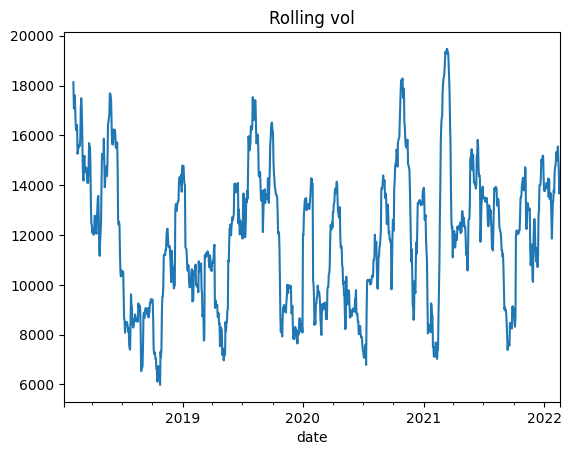

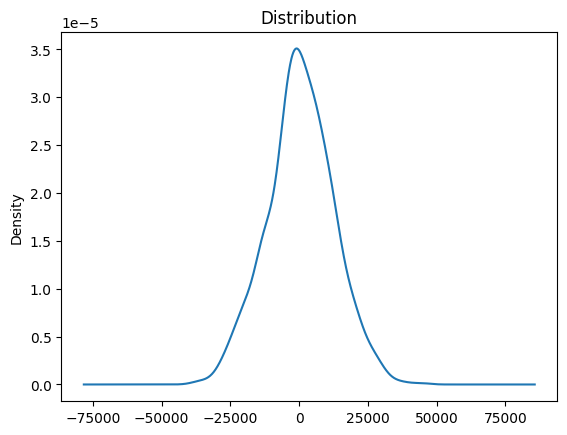

In [3]:
NFA_diff = data['NFA'].diff().dropna()
NFA_diff.plot(title = 'NFA diff');plt.show()
NFA_diff.rolling(22).mean().plot(title = 'Rolling Mean');plt.show()
NFA_diff.rolling(22).std().plot(title = 'Rolling vol');plt.show()
NFA_diff.plot(kind='kde', title = 'Distribution');plt.show()

In [4]:
breaks = pd.Series(0., index = data.index, name = 'break')
breaks.loc['2020-01-06':] = 1.
adddates = pd.to_datetime(['2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24',
                      '2022-02-25', '2022-02-28', '2022-03-01', '2022-03-02',
                      '2022-03-03', '2022-03-04'])
breaks = pd.concat([breaks, pd.Series(1., index = adddates)])


In [5]:
import numpy as np
data = pd.concat([data, breaks.rename('break').to_frame()], axis=1)
data['trend'] = np.arange(len(data))
data['yealy_season'] = np.sin(2 * np.pi * data['trend']/ 260)
data['monthly_season'] = np.sin(2 * np.pi * data['trend']/ 22)
data['weekly_season'] = np.sin(2 * np.pi * data['trend']/ 5)

## Section 2: Model Definition

In [6]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS,
    StatsForecastAutoCES, 
    StatsForecastAutoTheta,
    StatsForecastMSTL,
    StatsForecastAutoTBATS,
)
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.arch import ARCH  

ForecastingModels = {
    "Naive": NaiveForecaster(),
    "Seasonal_Naive": NaiveForecaster(sp = 5),
    "AutoARIMA": StatsForecastAutoARIMA(
                    trend=False, seasonal=True,
                    max_D = 5, max_p= 10, max_q=10),
    "AutoETS": StatsForecastAutoETS(season_length=5),
    "AutoCES": StatsForecastAutoCES(season_length=5),
    "AutoTheta": StatsForecastAutoTheta(season_length=5),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=5, use_trend =True, use_boxcox=True),
    "MSTL": StatsForecastMSTL(season_length=5),
    'GARCH':  ARCH(mean='ARX', lags=5, vol='GARCH'),
    "Prophet": Prophet(yearly_seasonality=True, weekly_seasonality=True),
}
from forecast_combine import model_select as f
model = f.ForecastModelSelect(
            data= data,
            depvar_str = 'NFA',                 
            exog_l=['break'],
            model_exog_d = {'GARCH': ['trend', 'yealy_season', 
                                      'monthly_season', 'weekly_season']},
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            forecasters_d= ForecastingModels,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            nbest = 2)

/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Importing plotly failed. Interactive plots will not work.


### Cross validation Procedure

Number of Folds      : 53
Initial Window Size  : 808
Step Length          : 5
Forecast Horizon     : 10
First Cutoff         : 2021-02-05 00:00:00
Last Curoff          : 2022-02-04 00:00:00


<Axes: title={'center': 'Cross Validation Procedure'}, ylabel='Window number'>

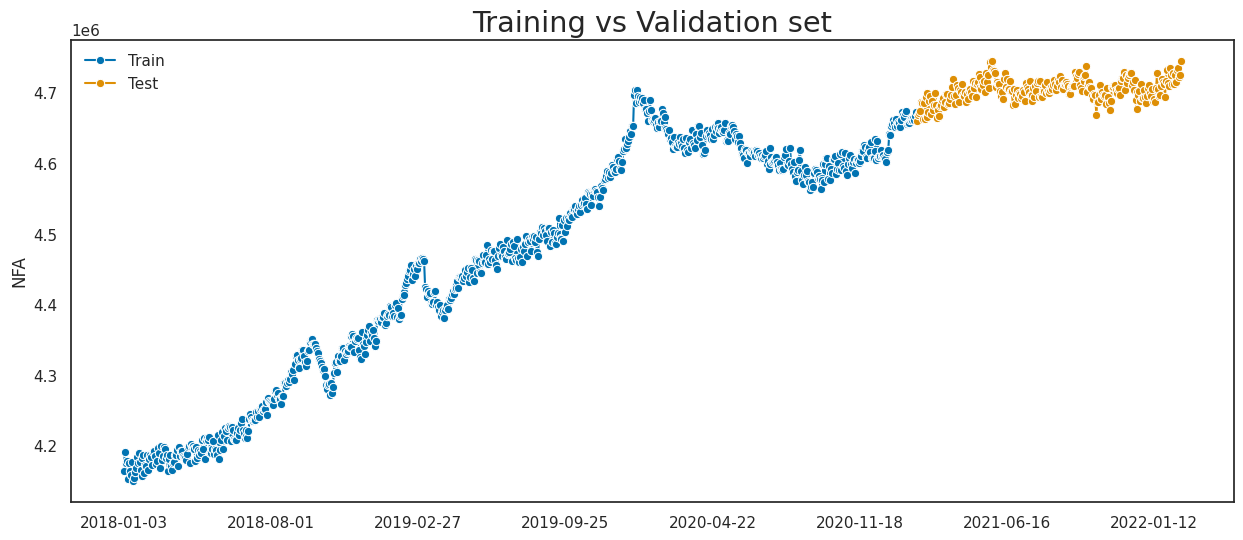

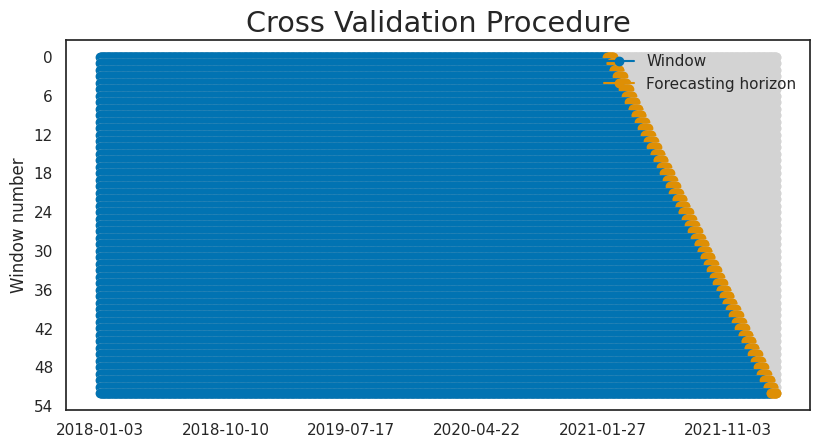

In [7]:
_ = model.split_procedure_summary()

model.plot_train_test(
    labels = ['Train', 'Test'],
    title='Training vs Validation set')

model.plot_cv_procedure(xlabel='')

### Out-Of-sample Evaluation

In [8]:
summary_horizon, summary_results = model.evaluate()


Start Naive forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future v

Evaluation completed in: 0.049 minutes

Start Seasonal_Naive forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/utils/seasonality.py:116: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  df.index = df.index.to_period(freq=freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/utils/seasonality.py:122: FutureWarning: PeriodDtype[B] is deprecated and will be removed in 

Evaluation completed in: 0.023 minutes

Start AutoARIMA forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/

Evaluation completed in: 0.591 minutes

Start AutoETS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future v

Evaluation completed in: 1.085 minutes

Start AutoCES forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future v

Evaluation completed in: 1.098 minutes

Start AutoTheta forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future v

Evaluation completed in: 0.866 minutes

Start AutoTBATS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated

Evaluation completed in: 0.508 minutes

Start MSTL forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future v

Evaluation completed in: 0.163 minutes

Start GARCH forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:901: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  absolute = absolute.to_timestamp(fh.freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return x.to_period(freq)
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/sktime/forecasting/base/_fh.py:959: FutureWarning: Period with BDay freq is deprecated and will be removed in a f

Evaluation completed in: 0.019 minutes

Start Prophet forecaster evalution....


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plot

Evaluation completed in: 0.029 minutes


In [9]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
AutoTheta,53,31.228468,0.463155,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12289.042138,10352.961421,0.002201,-0.801601,9432.044529
GARCH,53,0.496259,0.008101,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12347.580836,10380.304507,0.002207,-0.835554,9341.460007
AutoTBATS,53,22.236657,0.007663,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12353.277895,10428.85743,0.002217,-0.837238,9438.37593
AutoETS,53,49.040734,0.890157,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12380.3787,10484.706172,0.00223,-0.855107,9618.252984
AutoCES,53,54.697553,0.527004,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12461.580801,10573.094713,0.002249,-0.8905,9822.921463
Naive,53,0.003158,0.037415,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12833.157323,10817.871698,0.0023,-1.103052,9999.424528
MSTL,53,3.825663,0.169725,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,12936.702638,10877.023144,0.002313,-1.055059,9984.640263
Seasonal_Naive,53,0.003985,0.038103,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,15235.466272,12721.271698,0.002704,-1.922647,11684.754717
Prophet,53,0.737549,0.069945,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,15767.942241,13690.597261,0.00291,-2.655299,12705.228409
AutoARIMA,53,26.384243,2.386769,808,1068,2021-02-05 00:00:00,2022-02-04 00:00:00,23044.14597,21147.943757,0.004491,-6.704336,21071.961504


horizon                            1             2             3   \
Naive          RMSE      13121.914843  13155.879256  14151.363753   
               MAE       10396.849057  10476.886792  10978.188679   
               MAPE          0.002211      0.002228      0.002333   
               R2            0.384190      0.255587      0.062300   
               MedianAE  10411.000000   8288.000000   7935.000000   
Seasonal_Naive RMSE      15153.803337  14859.930900  15193.757252   
               MAE       12090.169811  12326.037736  12530.490566   
               MAPE          0.002569      0.002619      0.002662   
               R2            0.178712      0.050254     -0.080930   
               MedianAE  11451.000000  11196.000000  13093.000000   
AutoARIMA      RMSE      22225.004059  23944.650811  23146.919027   
               MAE       19160.024519  21412.839567  19862.944294   
               MAPE          0.004068      0.004547      0.004218   
               R2           -0.766590     -1.465989     -1.508728   
               MedianAE  19739.312641  22457.552265  17656.714355   
AutoETS        RMSE      11640.432544  11860.255138  12318.536914   
               MAE        9297.351335   9875.111633  10007.968520   
               MAPE          0.001976      0.002099      0.002127   
               R2            0.515392      0.394991      0.289465   
               MedianAE   8571.378353   9023.960651   9046.172771   
AutoCES        RMSE      11848.970014  11922.776533  12485.599444   
               MAE        9439.091060   9856.833033  10258.309385   
               MAPE          0.002007      0.002096      0.002181   
               R2            0.497873      0.388595      0.270062   
               MedianAE   7862.291138   8702.261841   9608.483765   
AutoTheta      RMSE      11770.189579  11875.943610  12339.609854   
               MAE        9368.899314   9869.504805  10023.320128   
               MAPE          0.001992      0.002098      0.002130   
               R2            0.504528      0.393389      0.287032   
               MedianAE   8131.247120   8888.261138   8851.359322   
AutoTBATS      RMSE      11658.630265  11922.658770  12289.590537   
               MAE        9348.512123   9969.348456   9884.909439   
               MAPE          0.001987      0.002119      0.002101   
               R2            0.513876      0.388607      0.292800   
               MedianAE   8431.848633   9760.533774   8495.198902   
MSTL           RMSE      12293.279950  12678.111324  13240.153482   
               MAE        9719.113807  10384.400761  10717.438449   
               MAPE          0.002066      0.002208      0.002278   
               R2            0.459510      0.308673      0.179170   
               MedianAE   7943.705493   8556.852431  10379.934052   
GARCH          RMSE      11631.593490  12030.045466  12356.847676   
               MAE        9305.063602  10077.343557   9929.747161   
               MAPE          0.001978      0.002142      0.002110   
               R2            0.516128      0.377544      0.285039   
               MedianAE   8998.111090   9869.617914   8924.495999   
Prophet        RMSE      15412.683176  15388.445050  13523.380238   
               MAE       12403.342082  13328.239833  10377.414606   
               MAPE          0.002636      0.002833      0.002206   
               R2            0.150411     -0.018506      0.143677   
               MedianAE  10699.777198  13353.467141   7676.166424   

horizon                            4             5             6   \
Naive          RMSE      13886.083736  12572.023201  14534.760444   
               MAE       11179.735849   9846.150943  12351.811321   
               MAPE          0.002379      0.002093      0.002625   
               R2            0.362252     -0.108799      0.181963   
               MedianAE  10368.000000   8173.000000  11618.000000   
Seasonal_Naive RMSE      16459.882093  12572.023201  17286.325221 

In [10]:
rank, score = model.select_best(score = 'MAPE')
display(rank)
display(score)

horizon,1,2,3,4,5,6,7,8,9,10
Best_1,AutoETS,AutoCES,AutoTBATS,AutoTheta,AutoETS,AutoTheta,Naive,GARCH,GARCH,AutoTheta
Best_2,GARCH,AutoTheta,GARCH,GARCH,AutoCES,GARCH,AutoTheta,AutoTheta,AutoTheta,GARCH
Best_3,AutoTBATS,AutoETS,AutoETS,AutoTBATS,MSTL,AutoETS,AutoETS,AutoTBATS,Naive,AutoETS
Best_4,AutoTheta,AutoTBATS,AutoTheta,AutoCES,AutoTheta,AutoTBATS,AutoCES,AutoETS,AutoTBATS,AutoCES
Best_5,AutoCES,GARCH,AutoCES,AutoETS,AutoTBATS,AutoCES,AutoTBATS,Naive,AutoCES,AutoTBATS
Best_6,MSTL,MSTL,Prophet,Naive,GARCH,Naive,GARCH,MSTL,AutoETS,MSTL
Best_7,Naive,Naive,MSTL,MSTL,Seasonal_Naive,MSTL,MSTL,AutoCES,MSTL,Seasonal_Naive
Best_8,Seasonal_Naive,Seasonal_Naive,Naive,Seasonal_Naive,Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Naive
Best_9,Prophet,Prophet,Seasonal_Naive,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet
Best_10,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA


,Naive,Seasonal_Naive,AutoARIMA,AutoETS,AutoCES,AutoTheta,AutoTBATS,MSTL,GARCH,Prophet,Best Model (over all),Best Model (per horizon),Best 2 Models (over all),Best 2 Models (per horizon),Model Avg (all models)
horizon,,,,,,,,,,,,,,,
1,0.002211,0.002569,0.004068,0.001976,0.002007,0.001992,0.001987,0.002066,0.001978,0.002636,0.001992,0.001976,0.001985,0.001977,0.002349
2,0.002228,0.002619,0.004547,0.002099,0.002096,0.002098,0.002119,0.002208,0.002142,0.002833,0.002098,0.002096,0.002120,0.002097,0.002499
3,0.002333,0.002662,0.004218,0.002127,0.002181,0.002130,0.002101,0.002278,0.002110,0.002206,0.002130,0.002101,0.002120,0.002105,0.002435
4,0.002379,0.002842,0.003992,0.002311,0.002302,0.002265,0.002285,0.002445,0.002277,0.002926,0.002265,0.002265,0.002271,0.002271,0.002602
5,0.002093,0.002093,0.004691,0.002002,0.002007,0.002043,0.002044,0.002037,0.002058,0.002355,0.002043,0.002002,0.002051,0.002004,0.002342
6,0.002625,0.002967,0.004506,0.002567,0.002604,0.002548,0.002573,0.002664,0.002558,0.003391,0.002548,0.002548,0.002553,0.002553,0.002900
7,0.002230,0.003145,0.004915,0.002289,0.002307,0.002277,0.002325,0.002366,0.002335,0.003473,0.002277,0.002230,0.002306,0.002254,0.002766
8,0.002126,0.002640,0.004499,0.002082,0.002156,0.001994,0.001999,0.002154,0.001950,0.002794,0.001994,0.001950,0.001972,0.001972,0.002440
9,0.002326,0.003051,0.004491,0.002475,0.002449,0.002317,0.002360,0.002523,0.002295,0.003503,0.002317,0.002295,0.002306,0.002306,0.002779


<Axes: title={'center': 'Out of Sample Performance'}, xlabel='horizon', ylabel='MAPE'>

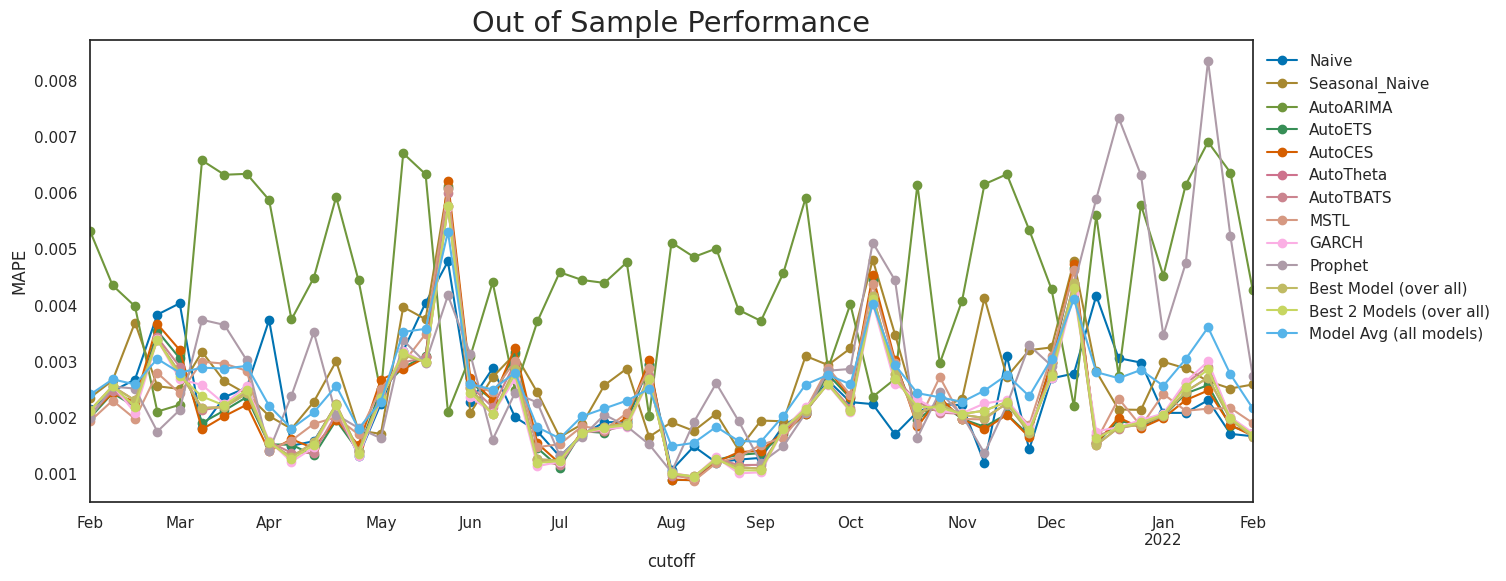

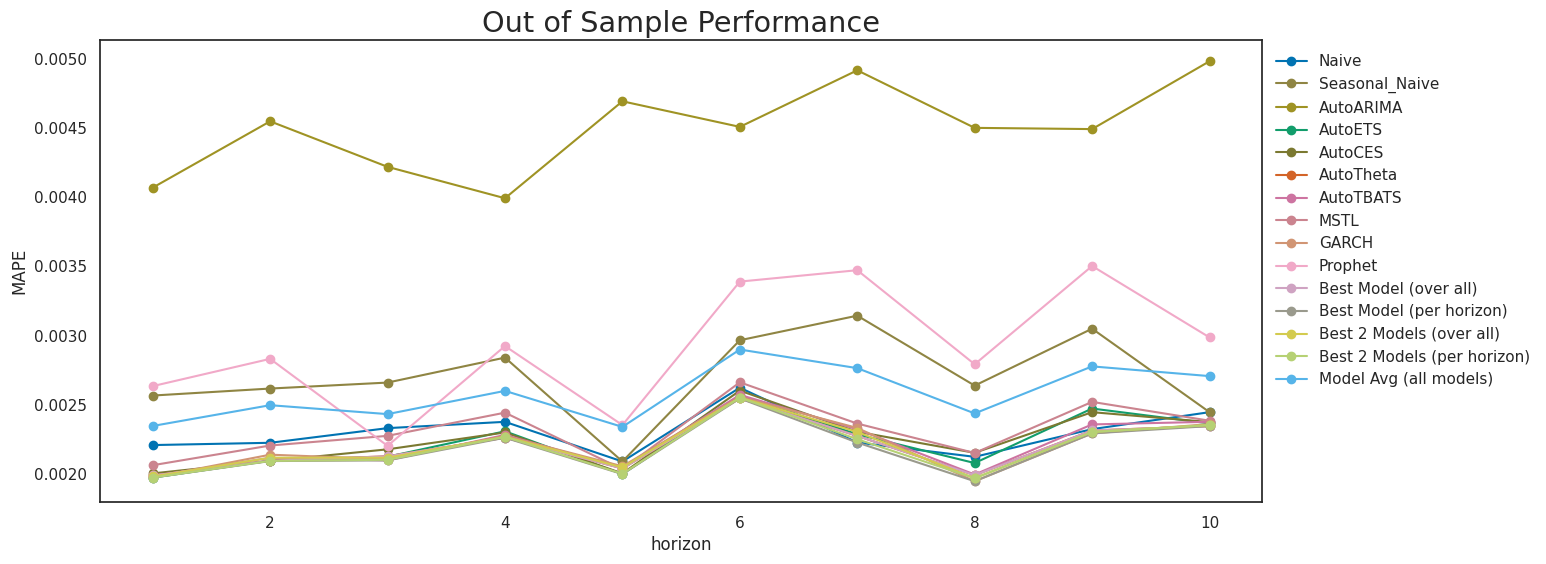

In [11]:
subset = ['AutoCES', 'AutoTheta', 'AutoTBATS', 'GARCH']
model.plot_model_compare(score ='MAPE', view = 'cutoff')#, model_subset=subset)
model.plot_model_compare(score ='MAPE', view = 'horizon')#, model_subset=subset + ['Best Model (per horizon)'])

In [12]:
X = data[['break']]
X['trend'] = np.arange(len(data))
X['yealy_season'] = np.sin(2 * np.pi * X['trend']/ 260)
X['monthly_season'] = np.sin(2 * np.pi * X['trend']/ 22)
X['weekly_season'] = np.sin(2 * np.pi * X['trend']/ 5)

10:07:59 - cmdstanpy - INFO - Chain [1] start processing
10:08:00 - cmdstanpy - INFO - Chain [1] done processing


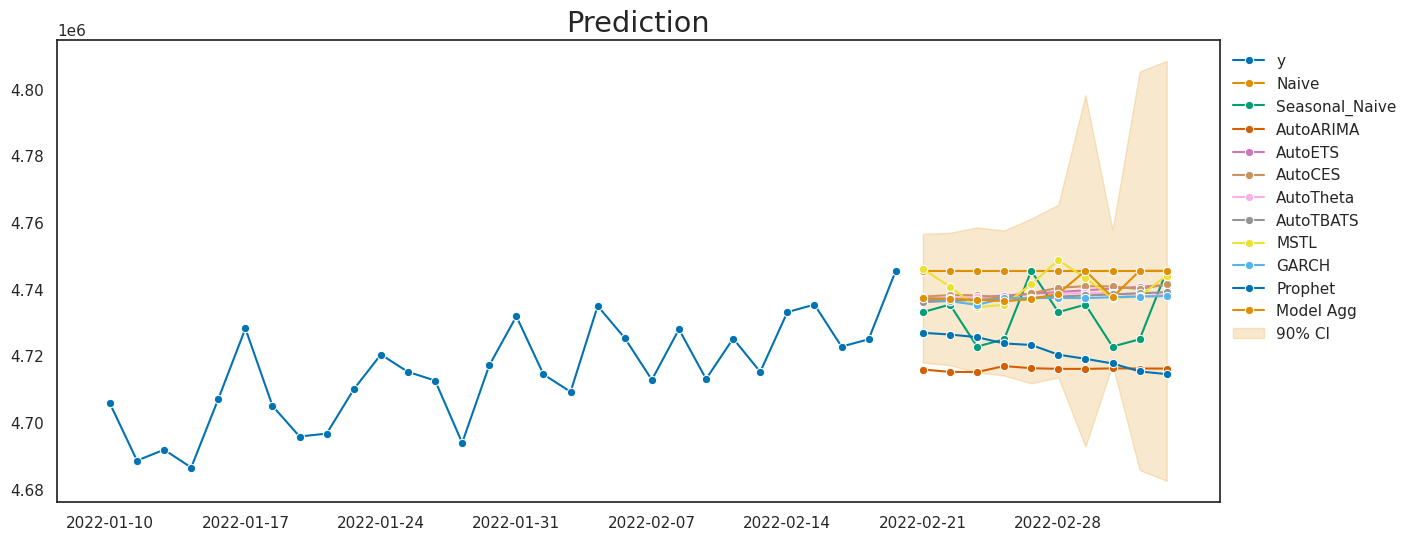

In [13]:
y_pred, y_pred_ints, preds, pred_ints = model.predict(X, 
                                                    mode='best_horizon',
                                                    ret_underlying=True)
f, ax =model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)                 

In [14]:
model.get_pred_errors()

,cutoff,horizon,error
0,2021-02-05,1,-10724.717713
1,2021-02-12,1,5375.858984
2,2021-02-19,1,-15063.895104
3,2021-02-26,1,-23447.838718
4,2021-03-05,1,-8998.111090
...,...,...,...
525,2022-01-07,10,13996.000000
526,2022-01-14,10,10090.000000
527,2022-01-21,10,15340.000000
528,2022-01-28,10,-1959.000000


In [15]:
path = '../model_output/NFA_forecast.pkl'
model.save(path)